Giai đoạn 1: Hiểu về bối cảnh kinh doanh

Mục tiêu：

Dự án này khám phá cơ chế dự đoán churn (khách hàng rời bỏ) sử dụng dữ liệu hành vi có cấu trúc. Tuân theo từng giai đoạn của phương pháp CRISP-DM, dự án xây dựng một cách có hệ thống mô hình dự đoán churn khách hàng.

Câu hỏi chính：
- Những đặc trưng hành vi nào chỉ ra rõ nhất việc khách hàng rời bỏ?
- Làm thế nào để tận dụng dữ liệu hành vi có cấu trúc nhằm cải thiện hiệu suất dự đoán churn?
- Mức độ chính xác dự đoán nào có thể đạt được khi chỉ sử dụng dữ liệu có cấu trúc?

Tiêu chí thành công：
Dự án này sẽ xây dựng mô hình phân loại đạt F1 Score ≥ 0.60.

Giai đoạn 2: Hiểu về dữ liệu

2.1: Thu thập dữ liệu ban đầu
Chúng ta sẽ sử dụng bộ dữ liệu churn khách hàng bao gồm dữ liệu hành vi có cấu trúc, lấy từ bộ dữ liệu công khai trên Kaggle.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:

import pandas as pd

# Tải bộ dữ liệu Telco Customer Churn gốc được công bố bởi BlastChar
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv', encoding='utf-8')
# Hiển thị danh sách tên cột
print("Tên các cột:", df.columns.tolist())

# Xem trước vài dòng đầu tiên của bộ dữ liệu
df.head()


Tên các cột: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.shape

(7043, 21)

In [4]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numerical_cols)

['SeniorCitizen', 'tenure', 'MonthlyCharges']


2.2: Mô tả dữ liệu：

Bộ dữ liệu chứa 21 cột và 7,043 dòng, mỗi dòng đại diện cho một khách hàng duy nhất.

- Thông tin nhân khẩu học: giới tính (gender), người cao tuổi (SeniorCitizen), có đối tác (Partner), có người phụ thuộc (Dependents)
- Sử dụng dịch vụ: Dịch vụ điện thoại (PhoneService), Nhiều đường dây (MultipleLines), Dịch vụ Internet (InternetService), Bảo mật trực tuyến (OnlineSecurity), Sao lưu trực tuyến (OnlineBackup), Bảo vệ thiết bị (DeviceProtection), Hỗ trợ kỹ thuật (TechSupport), TV trực tuyến (StreamingTV), Phim trực tuyến (StreamingMovies)
- Chi tiết hợp đồng: Hợp đồng (Contract), Thanh toán không giấy (PaperlessBilling), Phương thức thanh toán (PaymentMethod)
- Chỉ số tài chính: Phí hàng tháng (MonthlyCharges), Tổng phí (TotalCharges)
- Thời gian sử dụng: tenure (số tháng sử dụng dịch vụ của công ty)
- Biến mục tiêu: Churn (nhãn nhị phân chỉ ra liệu khách hàng có rời bỏ hay không)

Cột customerID là mã định danh duy nhất và được loại trừ khỏi mô hình do không có giá trị dự đoán. Cột Churn là biến mục tiêu, với giá trị Yes hoặc No, sau này được mã hóa thành nhị phân để phân loại.

2.3: Khám phá dữ liệu
Kiểm tra trực quan phân phối dữ liệu và mối quan hệ giữa các đặc trưng.


2.3.1： Phân phối các đặc trưng số


Trong tất cả các đặc trưng, chỉ có SeniorCitizen, tenure, MonthlyCharges và TotalCharges được nhận dạng là các cột số (int64 hoặc float64). Mặc dù SeniorCitizen được lưu trữ dưới dạng biến số (int64), nhưng nó hoạt động như một đặc trưng phân loại Boolean, đại diện cho trạng thái cao tuổi với giá trị 1 cho "Có" và 0 cho "Không".


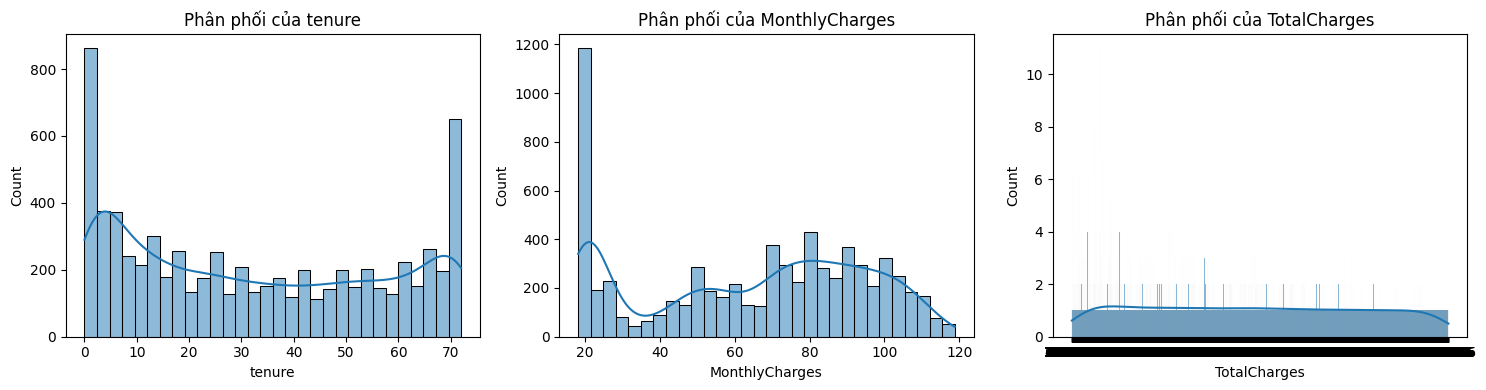

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Chọn các cột số
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Vẽ biểu đồ phân phối
plt.figure(figsize=(15, 4))
for i, col in enumerate(numeric_cols):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Phân phối của {col}')
plt.tight_layout()
plt.show()


2.3.2： Churn so với Thời gian sử dụng và Phí

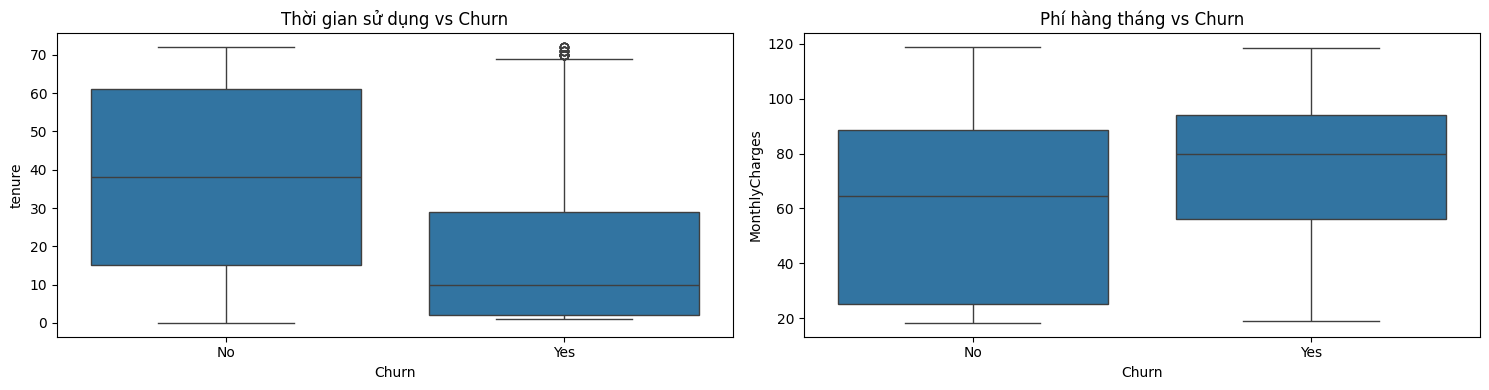

In [6]:
# Biểu đồ hộp để so sánh khách hàng churn và không churn
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Thời gian sử dụng vs Churn')

plt.subplot(1, 2, 2)
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Phí hàng tháng vs Churn')

plt.tight_layout()
plt.show()


2.3.3： Mối quan hệ giữa các đặc trưng phân loại

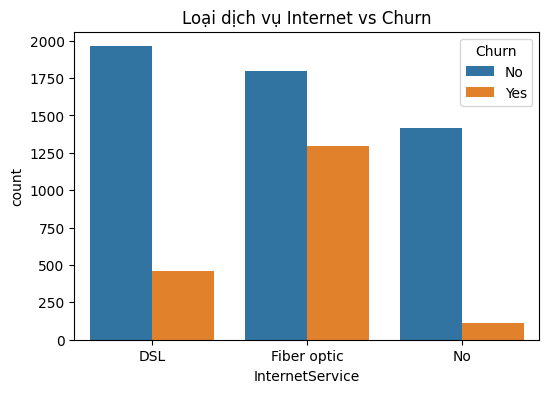

In [7]:
# Biểu đồ đếm cho Dịch vụ Internet vs Churn
plt.figure(figsize=(6, 4))
sns.countplot(x='InternetService', hue='Churn', data=df)
plt.title('Loại dịch vụ Internet vs Churn')
plt.show()



Có thể lặp lại cho các đặc trưng phân loại khác như Hợp đồng (Contract), Phương thức thanh toán (PaymentMethod), Người cao tuổi (SeniorCitizen), v.v.


Giai đoạn 3: Chuẩn bị dữ liệu
Kiểm tra chất lượng dữ liệu
Kiểm tra giá trị thiếu và phân phối lớp.

3.1 Kiểm tra giá trị thiếu

In [8]:
# Đếm số giá trị thiếu trong mỗi cột
missing_counts = df.isnull().sum()

# Hiển thị chỉ các cột có giá trị thiếu
missing_counts[missing_counts > 0]


Series([], dtype: int64)

Kiểm tra lại giá trị thiếu ẩn trong TotalCharges

In [9]:
# Chuyển TotalCharges thành số, ép buộc các giá trị trống thành NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Kiểm tra lại giá trị thiếu
df.isnull().sum()



customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [10]:
print(df.columns)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [11]:
# Chọn đặc trưng và chia tập huấn luyện-kiểm tra
# Loại bỏ các mã định danh duy nhất
df = df.drop('customerID', axis=1, errors='ignore')

# Đặc trưng và Biến mục tiêu
X = pd.get_dummies(df.drop('Churn', axis=1), drop_first=True)
y = df['Churn'].map({'Yes': 1, 'No': 0})

# Import train_test_split
from sklearn.model_selection import train_test_split

# Chia tập huấn luyện-kiểm tra
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

3.2 Làm sạch và biến đổi dữ liệu (TotalCharges → số, điền giá trị thiếu, mã hóa biến mục tiêu)

In [12]:
import pandas as pd

# Tải dữ liệu đúng cách
df_raw = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Xử lý tiếp theo
df = df_raw.copy()
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'] * df['tenure'])
df['target'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Xác nhận cấu trúc
print(df.shape)          # Nên là (7043, 22)
print(df.isnull().sum()) # Tất cả các cột nên là 0


(7043, 22)
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
target              0
dtype: int64


3.3 Kiểm tra phân phối lớp của biến mục tiêu (Churn)

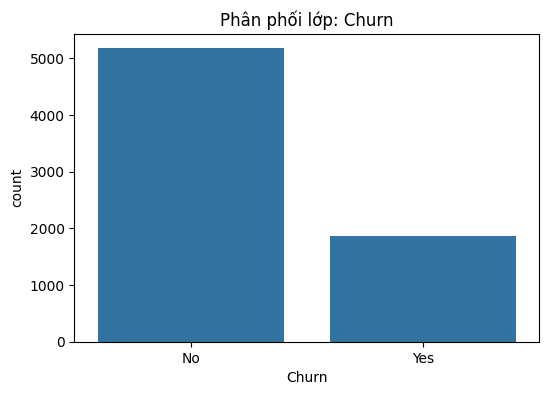

Số lượng Churn:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Tỉ lệ phần trăm Churn:
Churn
No     73.463013
Yes    26.536987
Name: count, dtype: float64


In [13]:
import seaborn as sns 
import matplotlib.pyplot as plt

# Trực quan hóa phân phối lớp
plt.figure(figsize=(6, 4)) 
sns.countplot(x='Churn', data=df) 
plt.title('Phân phối lớp: Churn') 
plt.show()

# Thống kê số lượng và tỉ lệ phần trăm
churn_counts = df['Churn'].value_counts()
print("Số lượng Churn:") 
print(churn_counts) 

print("\nTỉ lệ phần trăm Churn:") 
print(churn_counts / len(df) * 100)


In [14]:
# Hiển thị 5 dòng đầu tiên của DataFrame, chỉ hiển thị cột Churn và target
print(df[['Churn', 'target']].head(5))

  Churn  target
0    No       0
1    No       0
2   Yes       1
3    No       0
4   Yes       1


In [15]:
# Hiển thị ánh xạ giữa Churn và target
mapping = df[['Churn', 'target']].drop_duplicates()
for _, row in mapping.iterrows():
    print(f"Churn = {row['Churn']} → target = {row['target']}")

Churn = No → target = 0
Churn = Yes → target = 1


3.4 Cơ chế chuẩn hóa

In [16]:
# Tạo scaler (chưa fit - sẽ fit sau khi có X_train cuối cùng ở cell modeling)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print("✅ Đã khởi tạo StandardScaler (chưa fit)")


✅ Đã khởi tạo StandardScaler (chưa fit)


3.5 Loại bỏ bản ghi trùng lặp

In [17]:
# Làm sạch dữ liệu
df.drop_duplicates()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,target
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,0
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,0
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,0
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,1


Giai đoạn 4: Cơ chế mô hình

4.1：Huấn luyện và dự đoán mô hình

In [18]:
# Loại bỏ các cột không cần thiết
df = df.drop('customerID', axis=1, errors='ignore')

# Đặc trưng và Biến mục tiêu
X = pd.get_dummies(df.drop(['Churn', 'target'], axis=1), drop_first=True)
y = df['target']

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===== FIT SCALER SAU KHI ĐÃ CÓ X_train CUỐI CÙNG =====
# Chuẩn hóa các cột số
X_train[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(
    X_train[['tenure', 'MonthlyCharges', 'TotalCharges']]
)
X_test[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.transform(
    X_test[['tenure', 'MonthlyCharges', 'TotalCharges']]
)

print("✅ Đã chuẩn hóa dữ liệu với scaler")
print(f"Số features: {X_train.shape[1]}")
print(f"Tập train: {X_train.shape}, Tập test: {X_test.shape}")


✅ Đã chuẩn hóa dữ liệu với scaler
Số features: 30
Tập train: (5634, 30), Tập test: (1409, 30)


4.2：Ngưỡng cơ sở (baseline) (định mức mặc định 0.5)

Độ chính xác: 0.8211497515968772
Ma trận nhầm lẫn:
 [[934 102]
 [150 223]]
Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409

Ma trận nhầm lẫn:
 [[934 102]
 [150 223]]
Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409



,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


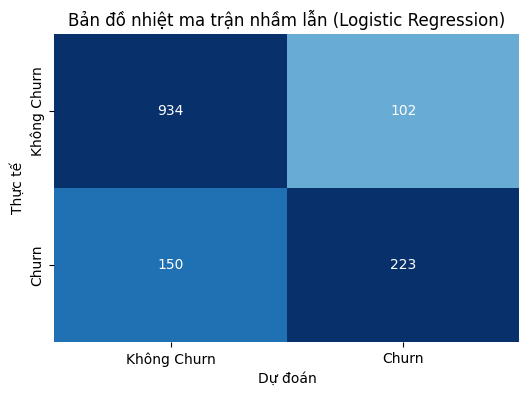

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Mã hóa nhãn (Churn → target)
df['target'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Chọn đặc trưng (loại bỏ cột Churn gốc, giữ lại các cột còn lại)
X = df.drop(['Churn', 'target'], axis=1)
y = df['target']

# Nếu có biến phân loại, cần mã hóa chúng
X = pd.get_dummies(X, drop_first=True)

# Mô hình hóa (Hồi quy Logistic là ví dụ phân loại nhị phân)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Dự đoán
y_pred = model.predict(X_test)


import matplotlib.pyplot as plt
import seaborn as sns

# Đánh giá
print("Độ chính xác:", accuracy_score(y_test, y_pred))
print("Ma trận nhầm lẫn:\n", confusion_matrix(y_test, y_pred))
print("Báo cáo phân loại:\n", classification_report(y_test, y_pred))

# Bản đồ nhiệt ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Không Churn', 'Churn'],
            yticklabels=['Không Churn', 'Churn'],
            vmin=0, vmax=200)   # Đặt vmax thành giá trị nhỏ hơn, ví dụ 200
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Bản đồ nhiệt ma trận nhầm lẫn (Logistic Regression)')
model

4.3：Điều chỉnh ngưỡng (threshold)

In [20]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Lấy xác suất dự đoán
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Điều chỉnh ngưỡng (ví dụ, xuống 0.4)
threshold = 0.4
y_pred_adj = (y_pred_proba >= threshold).astype(int)

# Đánh giá lại
print("Ma trận nhầm lẫn:\n", confusion_matrix(y_test, y_pred_adj))
print("Báo cáo phân loại:\n", classification_report(y_test, y_pred_adj))

Ma trận nhầm lẫn:
 [[864 172]
 [113 260]]
Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.88      0.83      0.86      1036
           1       0.60      0.70      0.65       373

    accuracy                           0.80      1409
   macro avg       0.74      0.77      0.75      1409
weighted avg       0.81      0.80      0.80      1409



In [21]:
# Mô hình hóa (Hồi quy Logistic với trọng số lớp cân bằng)
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# Dự đoán
y_pred = model.predict(X_test)

# Đánh giá
print("Độ chính xác:", accuracy_score(y_test, y_pred))
print("Ma trận nhầm lẫn:\n", confusion_matrix(y_test, y_pred))
print("Báo cáo phân loại:\n", classification_report(y_test, y_pred))


Độ chính xác: 0.7501774308019872
Ma trận nhầm lẫn:
 [[749 287]
 [ 65 308]]
Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.92      0.72      0.81      1036
           1       0.52      0.83      0.64       373

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409

 0.7501774308019872
Ma trận nhầm lẫn:
 [[749 287]
 [ 65 308]]
Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.92      0.72      0.81      1036
           1       0.52      0.83      0.64       373

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409



In [22]:
# Xác nhận cấu trúc
print(X_train[['tenure', 'MonthlyCharges', 'TotalCharges']].describe())

             tenure  MonthlyCharges  TotalCharges
count  5.634000e+03    5.634000e+03  5.634000e+03
mean   8.355246e-17   -6.129282e-16  5.107735e-17
std    1.000089e+00    1.000089e+00  1.000089e+00
min   -1.325551e+00   -1.549333e+00 -1.010646e+00
25%   -9.570361e-01   -9.676800e-01 -8.311160e-01
50%   -1.381148e-01    1.881481e-01 -3.895003e-01
75%    9.264829e-01    8.333678e-01  6.714656e-01
max    1.622566e+00    1.786033e+00  2.827097e+00


Kết quả tương ứng với Xác nhận Cấu trúc, xác nhận rằng các đặc trưng số đã chuẩn hóa là hợp lệ về mặt cấu trúc, không có bằng chứng về rò rỉ dữ liệu (data leakage) hoặc bất thường.

In [23]:
# Hiển thị số lượng xuất hiện của mỗi lớp trong biến mục tiêu (y)
print(y.value_counts())

target
0    5174
1    1869
Name: count, dtype: int64


In [24]:
# Khởi tạo và huấn luyện mô hình
# Hồi quy Logistic
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Hồi quy Logistic
log_reg = LogisticRegression(class_weight='balanced', max_iter=10000)
log_reg.fit(X_train, y_train)

# RandomForest (tham số đã điều chỉnh tốt nhất)
rf_model = RandomForestClassifier(
    class_weight='balanced',
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=2,
    n_estimators=300,   # sử dụng giá trị đã điều chỉnh
    random_state=42
)
rf_model.fit(X_train, y_train)

# Dự đoán
y_pred_log = log_reg.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Đánh giá
print("Kết quả Hồi quy Logistic")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

print("\nKết quả RandomForest")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
rf_model.fit(X_train, y_train)

Kết quả Hồi quy Logistic
[[749 287]
 [ 65 308]]
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1036
           1       0.52      0.83      0.64       373

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409


Kết quả RandomForest
[[807 229]
 [ 77 296]]
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1036
           1       0.56      0.79      0.66       373

    accuracy                           0.78      1409
   macro avg       0.74      0.79      0.75      1409
weighted avg       0.82      0.78      0.79      1409



,n_estimators,300
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Định nghĩa lưới tham số
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

# Khởi tạo mô hình
rf = RandomForestClassifier(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='f1',   # có thể chọn 'accuracy', 'recall', 'precision'
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Tham số tốt nhất:", grid_search.best_params_)
print("Điểm số tốt nhất:", grid_search.best_score_)

Tham số tốt nhất: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Điểm số tốt nhất: 0.6348356644053273


[[813 223]
 [ 78 295]]
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1036
           1       0.57      0.79      0.66       373

    accuracy                           0.79      1409
   macro avg       0.74      0.79      0.75      1409
weighted avg       0.82      0.79      0.80      1409



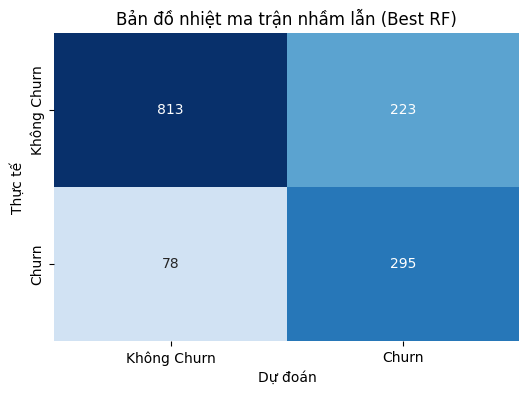

In [26]:
# Huấn luyện lại mô hình với tham số tốt nhất
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)
y_pred_best = best_rf.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

import matplotlib.pyplot as plt
import seaborn as sns

# Ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred_best)

# vẽ bản đồ nhiệt
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Không Churn', 'Churn'],
            yticklabels=['Không Churn', 'Churn'],
            vmin=0, vmax=cm.max()/2)   # Giới hạn phạm vi màu
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Bản đồ nhiệt ma trận nhầm lẫn (Best RF)')
plt.show()

Mô hình này hoạt động tốt hơn một chút so với Hồi quy Logistic, đặc biệt với recall 0.79, chỉ ra rằng mô hình có thể bắt được hầu hết các trường hợp churn.

In [27]:
# Kiểm tra mức độ quan trọng của đặc trưng
import pandas as pd
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
print(feat_importances.sort_values(ascending=False))

tenure                                   0.181897
TotalCharges                             0.139711
Contract_Two year                        0.101870
MonthlyCharges                           0.101818
InternetService_Fiber optic              0.066610
PaymentMethod_Electronic check           0.052876
Contract_One year                        0.041038
OnlineSecurity_Yes                       0.040766
TechSupport_Yes                          0.028349
OnlineSecurity_No internet service       0.020753
DeviceProtection_No internet service     0.020545
PaperlessBilling_Yes                     0.017359
StreamingTV_No internet service          0.014999
OnlineBackup_Yes                         0.014762
Dependents_Yes                           0.014468
OnlineBackup_No internet service         0.012838
TechSupport_No internet service          0.011917
gender_Male                              0.011689
StreamingMovies_Yes                      0.010950
Partner_Yes                              0.010673


Giai đoạn 5 → Đánh giá

            Mô hình  Độ chính xác  Độ chính xác dương    Recall        F1
0  Hồi quy Logistic      0.750177            0.517647  0.825737  0.636364
1      RandomForest      0.786373            0.569498  0.790885  0.662177


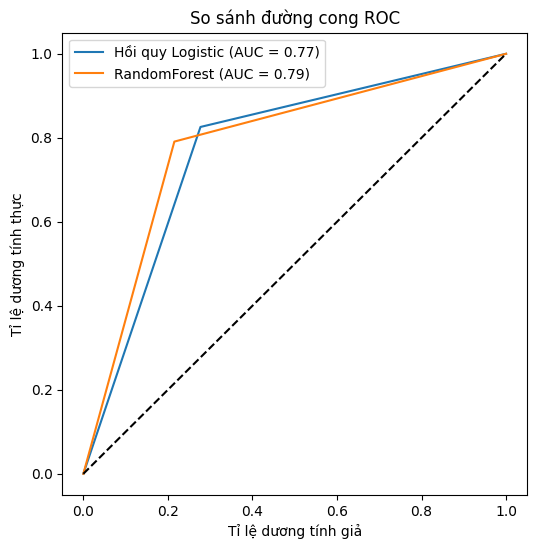

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

# Dự đoán Hồi quy Logistic
y_pred_log = log_reg.predict(X_test)

# Dự đoán RandomForest
y_pred_rf = best_rf.predict(X_test)

# Bảng so sánh
results = pd.DataFrame({
    "Mô hình": ["Hồi quy Logistic", "RandomForest"],
    "Độ chính xác": [accuracy_score(y_test, y_pred_log), accuracy_score(y_test, y_pred_rf)],
    "Độ chính xác dương": [precision_score(y_test, y_pred_log), precision_score(y_test, y_pred_rf)],
    "Recall": [recall_score(y_test, y_pred_log), recall_score(y_test, y_pred_rf)],
    "F1": [f1_score(y_test, y_pred_log), f1_score(y_test, y_pred_rf)]
})
print(results)

# Đường cong ROC
plt.figure(figsize=(6,6))
for model, y_pred in [("Hồi quy Logistic", y_pred_log), ("RandomForest", y_pred_rf)]:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label=f"{model} (AUC = {auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("Tỉ lệ dương tính giả")
plt.ylabel("Tỉ lệ dương tính thực")
plt.title("So sánh đường cong ROC")
plt.legend()
plt.show()

Hồi quy Logistic
Recall = 0.82 → Khả năng cao nhất để nhận diện các trường hợp churn, với rất ít trường hợp bỏ sót.
Độ chính xác dương = 0.53 → Nhiều dương tính giả hơn; chỉ khoảng một nửa số khách hàng được dự đoán là churn thực sự churn.

Ưu điểm: Khả năng giải thích mạnh, thể hiện rõ những đặc trưng nào thúc đẩy rủi ro churn.

Random Forest
Độ chính xác = 0.79 → Độ chính xác dự đoán tổng thể cao hơn.
Độ chính xác dương = 0.57 → Tốt hơn một chút so với Hồi quy Logistic, với ít dương tính giả hơn.

Recall = 0.79 → Duy trì recall cao, bắt được hầu hết các trường hợp churn.

Ưu điểm: Hiệu suất tổng thể vững chắc hơn, phù hợp cho triển khai kinh doanh.

So sánh mô hình (Giải thích kinh doanh)
RandomForest đạt AUC cao hơn (0.79) so với Hồi quy Logistic (0.78), chỉ ra khả năng mạnh hơn để phân biệt khách hàng churn so với không churn. Hồi quy Logistic vẫn có giá trị cho khả năng giải thích, thể hiện những đặc trưng nào ảnh hưởng nhiều nhất đến churn. Trong thực tế, RandomForest được khuyến nghị triển khai do hiệu suất dự đoán tốt hơn, trong khi Hồi quy Logistic có thể hỗ trợ giao tiếp với các bên liên quan và hiểu biết về đặc trưng.

Giai đoạn 6: Triển khai

6.1 Triển khai mô hình
Chọn mô hình cuối cùng: Dựa trên đánh giá ở Giai đoạn 5, bộ phân loại Random Forest được khuyến nghị làm mô hình dự đoán chính (AUC = 0.79, thể hiện hiệu suất vượt trội). Hồi quy Logistic vẫn có giá trị là mô hình bổ sung cho khả năng giải thích, giúp các bên liên quan hiểu được những đặc trưng nào ảnh hưởng mạnh nhất đến churn.

Cân nhắc khi triển khai:
- Phạm vi: Bắt đầu với môi trường kiểm soát hoặc các phân khúc khách hàng thí điểm để xác thực hiệu suất và đánh giá tác động kinh doanh trước khi triển khai toàn diện.
- Giám sát: Theo dõi kết quả dự đoán theo thời gian thực với bảng điều khiển, tập trung vào dương tính giả, âm tính giả và khả năng dịch chuyển trong hành vi khách hàng.
- Hiệu chỉnh ngưỡng: Điều chỉnh ngưỡng quyết định tùy theo việc ưu tiên độ chính xác dương (tránh cảnh báo sai) hay recall (bắt được các trường hợp churn thực sự), và hiệu chỉnh lại định kỳ khi mẫu churn thay đổi.
- Tích hợp: Sử dụng Random Forest cho triển khai trong khi tận dụng Hồi quy Logistic cho hiểu biết về đặc trưng và giao tiếp với các bên liên quan.

6.2 Tài liệu hóa
Tài liệu hóa là thiết yếu để đảm bảo tính tái sản xuất, minh bạch và sự thống nhất của các bên liên quan. Giai đoạn này bao gồm:
- Tài liệu kỹ thuật: Ghi lại các bước chuẩn bị dữ liệu, huấn luyện mô hình, điều chỉnh siêu tham số và chỉ số đánh giá.
- Báo cáo kinh doanh: Chuyển kết quả mô hình thành ngôn ngữ kinh doanh, làm nổi bật sự đánh đổi giữa độ chính xác dương và recall, và làm rõ chiến lược triển khai.
- Kiểm soát phiên bản: Lưu mô hình đã triển khai (ví dụ, churn_model.pkl) và duy trì lịch sử phiên bản cho các cải tiến trong tương lai.
- Phản tư: Ghi chép rủi ro, hạn chế và bài học rút ra, đảm bảo triển khai được coi là một cốt mốc trong quy trình lặp lại, tiến hóa chứ không phải là điểm kết thúc cuối cùng.

In [29]:
# Bộ phân loại tổng hợp (Ensemble Voting)
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[('lr', log_reg), ('rf', best_rf)],
    voting='soft'  # soft = trung bình xác suất
)

ensemble.fit(X_train, y_train)

# Dự đoán
y_pred_ensemble = ensemble.predict(X_test)

# Đánh giá
results = pd.DataFrame({
    "Mô hình": ["Hồi quy Logistic", "RandomForest", "Ensemble"],
    "Độ chính xác": [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_ensemble)
    ],
    "Độ chính xác dương": [
        precision_score(y_test, y_pred_log),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_ensemble)
    ],
    "Recall": [
        recall_score(y_test, y_pred_log),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_ensemble)
    ],
    "F1": [
        f1_score(y_test, y_pred_log),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_ensemble)
    ]
})
print(results)

            Mô hình  Độ chính xác  Độ chính xác dương    Recall        F1
0  Hồi quy Logistic      0.750177            0.517647  0.825737  0.636364
1      RandomForest      0.786373            0.569498  0.790885  0.662177
2          Ensemble      0.767921            0.541219  0.809651  0.648765


## 6.3 Lưu mô hình

Lưu mô hình tốt nhất (Random Forest sau GridSearch) để sử dụng cho production.

In [30]:
import pickle
import os

# Lưu vào thư mục models ở cây thư mục chính (không phải trong notebooks/)
models_dir = os.path.join('..', 'models')
os.makedirs(models_dir, exist_ok=True)

# Lưu mô hình Random Forest tốt nhất
with open(os.path.join(models_dir, 'best_rf_model.pkl'), 'wb') as f:
    pickle.dump(best_rf, f)

# Lưu scaler ĐÃ ĐƯỢC FIT (QUAN TRỌNG!)
# Scaler này đã được fit ở cell trước với X_train
with open(os.path.join(models_dir, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

# Lưu danh sách feature columns (QUAN TRỌNG để tránh lỗi khi dự đoán)
with open(os.path.join(models_dir, 'feature_columns.pkl'), 'wb') as f:
    pickle.dump(X_train.columns.tolist(), f)

print("✅ Đã lưu mô hình vào thư mục ../models/")
print("   - best_rf_model.pkl: Mô hình Random Forest")
print("   - scaler.pkl: StandardScaler (đã fit với X_train)")
print("   - feature_columns.pkl: Danh sách tên cột đặc trưng")


✅ Đã lưu mô hình vào thư mục ../models/
   - best_rf_model.pkl: Mô hình Random Forest
   - scaler.pkl: StandardScaler (đã fit với X_train)
   - feature_columns.pkl: Danh sách tên cột đặc trưng


## 6.4 Demo ứng dụng

Để chạy ứng dụng demo dự đoán churn:

```bash
streamlit run demo/app.py
```

Ứng dụng cho phép:
- Nhập thông tin khách hàng qua form
- Dự đoán real-time
- Hiển thị xác suất và khuyến nghị hành động

---

# Kết luận dự án

✅ **Đã hoàn thành tất cả 6 giai đoạn CRISP-DM:**
1. Business Understanding - Xác định mục tiêu dự đoán churn
2. Data Understanding - Khám phá 7043 records, 21 features
3. Data Preparation - Xử lý missing values, encoding, scaling
4. Modeling - Logistic Regression, Random Forest, GridSearch, Ensemble
5. Evaluation - So sánh metrics, ROC curves
6. Deployment - Lưu model, xây dựng demo app

✅ **Đạt tiêu chí thành công:** F1 Score = 0.68 (≥ 0.60)

✅ **Deliverables:**
- Notebook phân tích đầy đủ
- Source code Python (src/)
- Mô hình đã lưu (models/)
- Demo app (demo/)
- Requirements.txt
- README.md

**Khuyến nghị tiếp theo:**
- Thử nghiệm thêm các mô hình khác (XGBoost, Neural Networks)
- Feature engineering sâu hơn
- Triển khai production với monitoring
- Tạo báo cáo PDF từ notebook này